In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import jax.numpy as jnp
from jax import random, jit, grad

from flax import linen as nn
from flax.training.train_state import TrainState
import optax
from ode import odeint
from sklearn.datasets import make_circles, make_moons

import itertools
from functools import partial
from tqdm.auto import trange
from celluloid import Camera

import matplotlib.pylab as plt
%matplotlib inline

In [65]:
class MLP(nn.Module):
    num_layers: int=3
    hidden_dim: int=64
    out_dim: int = 2

    @nn.compact
    def __call__(self, x):
        for _ in range(self.num_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = nn.selu(x)
        x = nn.Dense(self.out_dim)(x)
        return x

In [66]:
class ConditionalFlowMatching():
    def __init__(self, inputs, sigma=0.1, rng_key=random.PRNGKey(0)):

        self.sigma = sigma

        model = MLP(
            num_layers=4,
            hidden_dim=256,
            out_dim=2
         )

        params = model.init(rng_key, inputs)

        tx = optax.adam(learning_rate=1e-3)
        
        self.state = TrainState.create(
            apply_fn=model.apply,
            params=params,
            tx=tx
        )

        self.loss_log = []
        self.itercount = itertools.count()

    def sample_conditional_path(self, x0, x1, t, eps):
        t = jnp.tile(t, (1, x1.shape[-1]))
        mu_t = (1.0 - t) * x0 + t * x1
        sigma_t = self.sigma
        x = mu_t + sigma_t * eps
        return x

    def loss(self, params, batch):
        x0, x1, t, eps = batch
        # Sample p(x|t,z)
        x = self.sample_conditional_path(x0, x1, t, eps)
        # Get velocity predictions
        outputs = self.state.apply_fn(params, jnp.concatenate([x, t], axis=-1))
        # True velocity targets
        targets = x1 - x0
        loss = jnp.mean((outputs-targets)**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def eval_loss(self, params, batch):
        return self.loss(params, batch)

    @partial(jit, static_argnums=(0,))
    def step(self, state, batch):
        grads = grad(self.loss)(state.params, batch)
        state = state.apply_gradients(grads=grads)
        return state

    def train(self, source_generator, target_generator, batch_size=64, max_steps=1000):
        rng_key = random.PRNGKey(0)
        pbar = trange(max_steps)
        for it in pbar:
            rng_key, subkey_1, subkey_2 = random.split(rng_key, 3)
            x0 = source_generator(batch_size)
            x1 = target_generator(batch_size)
            t = random.uniform(subkey_1, (batch_size, 1))
            eps = random.normal(subkey_2, x0.shape)
            batch = (x0, x1, t, eps)
            self.state = self.step(self.state, batch)
            if it % 10 == 0:
                loss = self.eval_loss(self.state.params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

In [67]:
def get_batch_circles(num_samples):
    """Adapted from the Pytorch implementation at:
    https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py
    """
    points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
    x = jnp.array(points, dtype=jnp.float32)
    return x

def get_batch_moons(num_samples):
    points, _ = make_moons(n_samples=num_samples, noise=0.05)
    x = jnp.array(points, dtype=jnp.float32)
    return x

def get_batch_noise(num_samples):
    points = np.random.normal(size=(num_samples,2))
    x = jnp.array(points, dtype=jnp.float32)
    return x

def build_dataloader(dataset):
    if dataset == 'circles':
        get_batch = lambda num_samples: get_batch_circles(num_samples)
    elif dataset == 'moons':
        get_batch = lambda num_samples: get_batch_moons(num_samples)
    elif dataset == 'noise':
        get_batch = lambda num_samples: get_batch_noise(num_samples)
    return get_batch

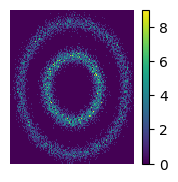

In [68]:
source_dataset = 'moons'
target_dataset = 'circles'
batch_size = 512
max_steps = 40000
sigma = 1e-2

source_generator = build_dataloader(source_dataset)
target_generator = build_dataloader(target_dataset)

data = target_generator(10_000)

plt.figure(figsize=(2,2))
plt.hist2d(data[:, 0], data[:, 1], bins=128)
plt.colorbar()
plt.axis('off')
plt.show()

In [69]:
# Initialize model
x = jnp.ones((batch_size, data.shape[-1]))
t = jnp.ones((batch_size,1))
inputs = jnp.concatenate([x, t], axis=-1)
model = ConditionalFlowMatching(inputs, sigma)

In [70]:
# Train
model.train(source_generator, 
            target_generator,
            batch_size, 
            max_steps)

100%|██████████| 40000/40000 [01:08<00:00, 583.30it/s, loss=0.48393542]


In [71]:
# Generate samples via ODE integration
@jit
def dynamics_fn(x, t):
    t = t * jnp.ones((x.shape[0],1))
    u_t = model.state.apply_fn(model.state.params, jnp.concatenate([x, t], axis=-1))
    return u_t

x0 = source_generator(10_000)
times = jnp.linspace(0, 1, 100, endpoint=True)
trajectory = odeint(dynamics_fn, x0, times, atol=1e-5, rtol=1e-5)

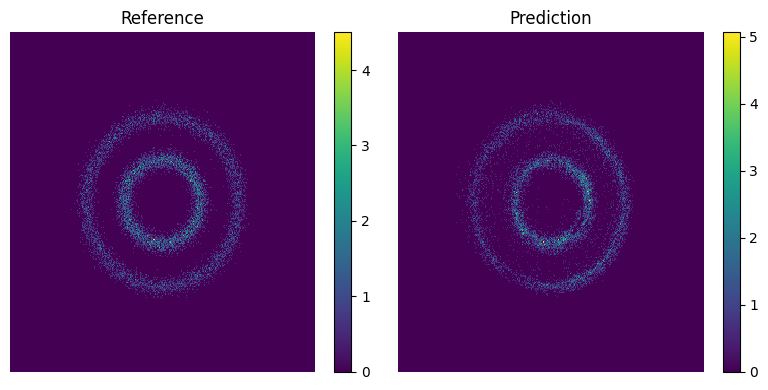

In [72]:
# Plot samples
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.hist2d(data[:,0],
           data[:,1], 
           bins=300, 
           density=True, 
           range=[[-2.0, 2.0], [-2.0, 2.0]])
plt.title('Reference')
plt.colorbar()  
plt.axis('off')
plt.subplot(1,2,2)
plt.hist2d(trajectory[-1,:,0],
           trajectory[-1,:,1], 
           bins=300, 
           density=True, 
           range=[[-2.0, 2.0], [-2.0, 2.0]])
plt.title('Prediction')
plt.colorbar()  
plt.axis('off')
plt.tight_layout()
plt.show()

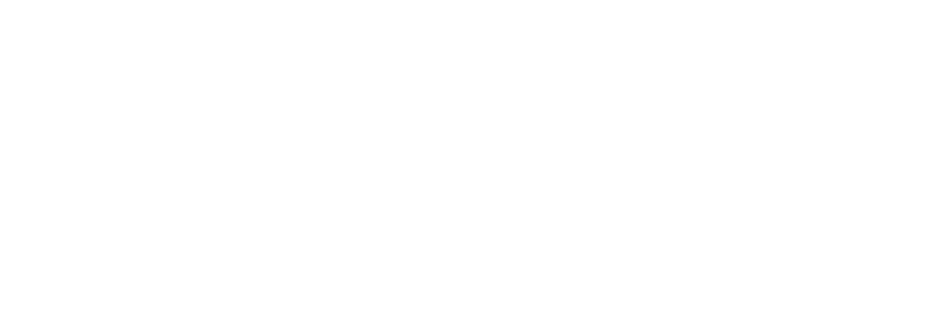

In [73]:
# Animate flow
fig, axes = plt.subplots(1,2,figsize=(12,4))
camera = Camera(fig)

for i in range(trajectory.shape[0]):
    axes[0].hist2d(data[:,0],
                   data[:,1], 
                   bins=300, 
                   density=True, 
                   range=[[-2.0, 2.0], [-2.0, 2.0]])
    axes[0].text(0.5, 1.01, 
                 'Reference', 
                 transform=axes[0].transAxes, 
                 ha="center", va="bottom")
    axes[0].axis('off')

    axes[1].hist2d(trajectory[i,:,0],
                   trajectory[i,:,1],
                   bins=300, 
                   density=True, 
                   range=[[-2.0, 2.0], [-2.0, 2.0]])
    axes[1].text(0.5, 1.01, 
                 'Prediction (t=%.2f)' % (times[i]), 
                 transform=axes[1].transAxes, 
                 ha="center", va="bottom")
    axes[1].axis('off')
    camera.snap()

animation = camera.animate()
animation.save('cfm_animation.gif')
